In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
log_train = r'./data/log_train.csv'
log_test = r'./data/log_test.csv'
train = r'./data/train.csv'
test = r'./data/test.csv'
sample_sub = r'./data/sample_submission.csv'


log_train_df = pd.read_csv(log_train)
log_test_df = pd.read_csv(log_test)
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)
sample_sub_df = pd.read_csv(sample_sub)

In [6]:
print(f"log_train {log_train_df.shape}")
print(f"log_test {log_test_df.shape}")
print(f"train {train_df.shape}")
print(f"test {test_df.shape}")

log_train (5710093, 5)
log_test (2447184, 5)
train (84377, 141)
test (35982, 140)


In [7]:
print(f"Submission Sample {sample_sub_df.shape}")

Submission Sample (35982, 2)


In [8]:
# For how many IDs do we have logs in train data
sum(train_df.ID.isin(log_train_df.ID))

47695

# LOG FILE PROCESSING

#### Converting to datetime

In [9]:
# Convert to Date time
log_train_df.time = pd.to_datetime(log_train_df.time, format="%Y-%m-%dT%H:%M:%S")

In [10]:
log_train_df['date_only'] = log_train_df['time'].dt.date
log_train_df['week_number'] = log_train_df['time'].dt.isocalendar().week

In [11]:
log_train_df.head(2)

,ID,time,source,event,object,date_only,week_number
0,43980,2013-11-11 16:30:11,browser,page_close,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,2013-11-11,46
1,2648,2013-12-27 06:44:08,browser,access,UaqaZdJXEAHfzB9qbZkvAe2jc0xmI3Na,2013-12-27,52


In [12]:
# Range of logs
min(log_train_df.date_only), max(log_train_df.date_only)

(datetime.date(2013, 10, 27), datetime.date(2014, 8, 1))

In [13]:
# Unique events we have
log_train_df['event'].unique()

array(['page_close', 'access', 'navigate', 'video', 'problem',
       'discussion', 'wiki'], dtype=object)

In [14]:
log_features_df = pd.DataFrame(log_train_df.ID.unique(), columns=['ID'])

#### Encoding Events in Logs

In [15]:
encoder = OneHotEncoder()
labelencoder = LabelEncoder()

In [16]:
log_train_df['event_categorical'] = labelencoder.fit_transform(log_train_df[['event']])

/Users/nmnsnghl/anaconda3/envs/torch_temp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
enc_df = pd.DataFrame(encoder.fit_transform(log_train_df[['event_categorical']]).toarray())
log_train_df = log_train_df.join(enc_df)

##### Renaming encoded columns

In [18]:
decoded_labels_event = list(labelencoder.inverse_transform([0,1,2,3,4,5,6]))
decoded_labels_event = list(map(lambda x: 'event_'+x,decoded_labels_event))
decoded_labels_event = dict(zip(range(len(labelencoder.classes_)), decoded_labels_event))

In [19]:
# Renaming encoded cols
log_train_df = log_train_df.rename(decoded_labels_event, axis=1)

In [20]:
# drop event and time
# log_train_df.drop(['event', 'event_categorical', 'time'], axis=1, inplace=True)

In [21]:
log_train_df.head(2)

,ID,time,source,event,object,date_only,week_number,event_categorical,event_access,event_discussion,event_navigate,event_page_close,event_problem,event_video,event_wiki
0,43980,2013-11-11 16:30:11,browser,page_close,3T6XwoiMKgol57cm29Rjy8FXVFcIomxl,2013-11-11,46,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2648,2013-12-27 06:44:08,browser,access,UaqaZdJXEAHfzB9qbZkvAe2jc0xmI3Na,2013-12-27,52,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Extraction from Logs

#### 1. Average session per week

In [22]:
sessions_by_week = log_train_df[['ID', 'week_number', 'source']].groupby(['ID', 'week_number']).count().reset_index()


In [23]:
processed_logs = sessions_by_week[['ID', 'source']].groupby(['ID']).mean('source').reset_index()
processed_logs.columns = ['ID', 'session_by_week']

#### 2. Active days per week

In [24]:
grouped_date_by_week = log_train_df.groupby(['ID', 'week_number', 'date_only']).count().reset_index()[['ID', 'week_number', 'date_only']]
grouped_date_by_week = grouped_date_by_week.groupby(['ID', 'week_number']).count().reset_index()

In [25]:
grouped_date_by_week.head(2)

,ID,week_number,date_only
0,1,24,1
1,1,25,3


In [26]:
active_per_week = grouped_date_by_week[['ID', 'date_only']].groupby(['ID']).mean('date_only').reset_index()
active_per_week.columns = ['ID', 'active_per_week']

In [27]:
# Merge to processed data
processed_logs = processed_logs.merge(active_per_week, on='ID')

#### 3. Each event average per week

In [28]:
events_by_week = log_train_df[['ID', 'week_number']+list(decoded_labels_event.values())]
events_by_week = events_by_week.groupby(['ID', 'week_number']).sum().reset_index()
events_by_week = events_by_week.groupby(['ID']).mean().reset_index().drop('week_number', axis=1)


In [29]:
events_by_week.columns = ['ID'] + list(map(lambda x: x + '_by_week', list(decoded_labels_event.values())))

In [30]:
# Merge to processed data
processed_logs = processed_logs.merge(events_by_week, on='ID')

In [31]:
processed_logs.head(5)

,ID,session_by_week,active_per_week,event_access_by_week,event_discussion_by_week,event_navigate_by_week,event_page_close_by_week,event_problem_by_week,event_video_by_week,event_wiki_by_week
0,1,47.40,2.80,17.00,0.0,3.4,10.40,12.20,4.4,0.0
1,3,39.00,1.80,11.00,3.8,2.0,3.80,17.00,1.4,0.0
2,4,17.75,2.25,11.75,0.0,2.5,1.25,1.25,1.0,0.0
3,5,86.60,2.20,32.00,4.2,3.8,13.00,22.20,11.4,0.0
4,6,16.00,2.00,10.00,0.0,4.0,0.00,2.00,0.0,0.0


## Loading Log processed file
This is the latest one with watch time processed in NeuralNetwork notebook

In [32]:
processed_logs = pd.read_csv('processed_logs.csv')

# TRAIN DATA PREP

In [33]:
train_df.label.value_counts()

label
1    66888
0    17489
Name: count, dtype: int64

Imbalanced dataset

In [34]:
train_df.describe()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,label
count,83912.000000,83959.000000,25179.0,83946.000000,25131.0,83947.000000,25137.0,25272.0,83967.000000,84008.000000,83975.000000,83987.000000,83955.000000,83973.000000,83929.000000,83963.000000,83962.000000,83959.000000,25240.0,25093.0,25197.0,25327.0,25281.0,25093.0,25230.0,83958.000000,83965.000000,83970.000000,83976.000000,83980.000000,83988.000000,83941.000000,83953.000000,83958.000000,83944.000000,83948.000000,83905.000000,83976.000000,25171.0,25436.0,25115.0,83978.000000,83928.000000,83930.000000,83970.000000,83974.000000,25211.0,83930.000000,83965.000000,83961.000000,83986.000000,25048.0,83951.000000,25099.0,25311.0,25099.0,83956.000000,83965.000000,25077.0,25161.0,25156.0,25098.0,25418.0,25140.0,83919.000000,83948.000000,25261.0,25184.0,25435.0,83939.000000,25055.0,25360.0,83950.000000,25060.0,83973.000000,25255.0,25385.0,83929.000000,83948.000000,83941.000000,83957.000000,83941.000000,83962.000000,83961.000000,83965.000000,83953.000000,83966.000000,83951.000000,25225.0,25196.0,83989.000000,25059.0,83949.000000,25235.0,25077.0,83960.000000,83968.000000,83968.000000,83953.000000,83971.000000,83963.000000,83956.000000,83928.000000,83940.000000,83952.000000,83991.000000,25141.0,83996.000000,83954.000000,83980.000000,84007.000000,83977.00000,83987.000000,83972.000000,83936.000000,83948.000000,83924.000000,83951.000000,83963.000000,25207.0,25337.0,83933.000000,83945.000000,25247.0,25044.0,83961.000000,83936.000000,83966.000000,83943.000000,25202.0,25392.0,25084.0,25185.0,25367.0,83936.000000,83985.000000,83967.000000,83929.000000,83966.000000,24981.0,84377.000000
mean,100386.093098,1.585512,0.0,11.740988,0.0,1.906763,0.0,0.0,9.415139,9.026486,8.502042,7.922631,12.688667,12.633084,12.551907,8.093160,8.052988,13.831430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.464363,12.650914,12.716625,12.850088,12.793498,12.518324,12.419068,12.467690,12.566521,12.744222,12.718552,2.238424,10.132216,0.0,0.0,0.0,11.176522,10.173101,10.701430,2.238883,12.504930,0.0,11.031371,11.236634,27.014054,1.000905,0.0,7.731510,0.0,0.0,0.0,7.316166,6.305294,0.0,0.0,0.0,0.0,0.0,0.0,1.000027,1.005212,0.0,0.0,0.0,1.005379,0.0,0.0,10.774771,0.0,2480.769307,0.0,0.0,6.824398,9.021037,9.182378,8.278190,12.029473,9.518056,8.967390,8.999464,8.849535,9.222435,9.869364,0.0,0.0,5.055471,0.0,9.413108,0.0,0.0,6.836446,8.840713,9.683141,10.946494,7.827309,7.863607,9.760779,12.341853,11.228651,10.792322,10.703159,0.0,12.306515,12.273638,12.440545,12.446260,12.90395,12.564635,12.469680,12.633816,4.208808,12.516813,12.551607,9.410776,0.0,0.0,5.061282,7.363285,0.0,0.0,1.142852,1.129956,11.095181,20.785152,0.0,0.0,0.0,0.0,0.0,2.381040,2.567792,2.254326,2.334092,5.735965,0.0,0.792728
std,57993.333045,0.535283,0.0,34.643444,0.0,1.036347,0.0,0.0,17.288043,15.491942,13.644927,12.402860,12.810191,12.963943,12.529402,14.503711,13.481138,28.882368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.875154,14.637749,13.891236,14.432178,14.334957,13.703340,13.278109,13.249692,13.267787,14.165527,14.466292,3.511218,30.026372,0.0,0.0,0.0,31.218848,30.090452,32.437012,3.507194,35.744037,0.0,29.840560,31.884643,54.615948,0.054987,0.0,22.415262,0.0,0.0,0.0,8.973501,11.724296,0.0,0.0,0.0,0.0,0.0,0.0,0.005613,0.301954,0.0,0.0,0.0,0.122192,0.0,0.0,7.008842,0.0,2114.301087,0.0,0.0,8.633683,13.711790,14.127946,12.354702,11.045928,19.138137,13.778297,13.594101,13.435822,13.798543,15.591675,0.0,0.0,7.904405,0.0,13.142299,0.0,0.0,5.876158,13.

##### Drop dummy columns

In [35]:
drop_cols = []
mean_of_train = pd.DataFrame(train_df.mean()).reset_index()
keep_features = mean_of_train[mean_of_train.iloc[:,-1]!=0.0]['index'].to_list()

In [36]:
def filter_dummy_cols(dataset, keep):
    return dataset[keep]

In [37]:
train_df = filter_dummy_cols(train_df, keep_features)
train_df.head(2)

,ID,X1,X3,X5,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X41,X42,X43,X44,X45,X47,X48,X49,X50,X52,X56,X57,X64,X65,X69,X72,X74,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X90,X92,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X121,X122,X125,X126,X127,X128,X134,X135,X136,X137,X138,label
0,7054.0,2.015152,32.0,4.0,7.0,6.0,2.0,5.0,2.0,15.0,16.0,6.0,9.0,10.0,8.0,1.0,14.0,16.0,39.0,16.0,13.0,8.0,4.0,15.0,4.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,21.0,1.0,10.0,9.142857,1.0,1.0,1.0,1.0,18.0,2574.0,5.83871,7.0,1.0,5.0,8.0,11.0,27.0,2.0,3.0,6.0,4.0,1.000000,5.0,4.0,5.0,4.0,1.0,1.0,4.0,5.0,16.0,13.0,7.0,13.0,14.0,5.0,13.0,9.0,15.0,2.0,14.0,6.0,2.0,11.0,4.0,5.0,2.0,10.0,1.0,1.0,18.0,13.0,1.0,1.0,1.0,3.0,2.0,1
1,147131.0,1.000000,2.0,NaN,6.0,5.0,8.0,4.0,7.0,12.0,1.0,4.0,7.0,3.0,13.0,7.0,13.0,15.0,17.0,12.0,14.0,8.0,9.0,4.0,14.0,1.0,1.0,2.0,2.0,11.0,1.0,2.0,1.0,1.0,4.0,1.0,2.0,1.000000,3.0,1.0,1.0,1.0,16.0,961.0,1.75188,1.0,10.0,6.0,8.0,3.0,3.0,11.0,9.0,9.0,3.0,1.862069,4.0,2.0,2.0,4.0,8.0,2.0,1.0,3.0,5.0,9.0,16.0,16.0,4.0,3.0,1.0,14.0,2.0,16.0,14.0,17.0,1.0,4.0,6.0,4.0,2.0,1.0,1.0,1.0,9.0,4.0,3.0,1.0,1.0,2.0,10.0,1


In [38]:
train_df.shape

(84377, 92)

So we removed 48 dummy columns, haha you can't trick me :)

In [39]:
train_df.describe()

,ID,X1,X3,X5,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X41,X42,X43,X44,X45,X47,X48,X49,X50,X52,X56,X57,X64,X65,X69,X72,X74,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X90,X92,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X121,X122,X125,X126,X127,X128,X134,X135,X136,X137,X138,label
count,83912.000000,83959.000000,83946.000000,83947.000000,83967.000000,84008.000000,83975.000000,83987.000000,83955.000000,83973.000000,83929.000000,83963.000000,83962.000000,83959.000000,83958.000000,83965.000000,83970.000000,83976.000000,83980.000000,83988.000000,83941.000000,83953.000000,83958.000000,83944.000000,83948.000000,83905.000000,83976.000000,83978.000000,83928.000000,83930.000000,83970.000000,83974.000000,83930.000000,83965.000000,83961.000000,83986.000000,83951.000000,83956.000000,83965.000000,83919.000000,83948.000000,83939.000000,83950.000000,83973.000000,83929.000000,83948.000000,83941.000000,83957.000000,83941.000000,83962.000000,83961.000000,83965.000000,83953.000000,83966.000000,83951.000000,83989.000000,83949.000000,83960.000000,83968.000000,83968.000000,83953.000000,83971.000000,83963.000000,83956.000000,83928.000000,83940.000000,83952.000000,83991.000000,83996.000000,83954.000000,83980.000000,84007.000000,83977.00000,83987.000000,83972.000000,83936.000000,83948.000000,83924.000000,83951.000000,83963.000000,83933.000000,83945.000000,83961.000000,83936.000000,83966.000000,83943.000000,83936.000000,83985.000000,83967.000000,83929.000000,83966.000000,84377.000000
mean,100386.093098,1.585512,11.740988,1.906763,9.415139,9.026486,8.502042,7.922631,12.688667,12.633084,12.551907,8.093160,8.052988,13.831430,12.464363,12.650914,12.716625,12.850088,12.793498,12.518324,12.419068,12.467690,12.566521,12.744222,12.718552,2.238424,10.132216,11.176522,10.173101,10.701430,2.238883,12.504930,11.031371,11.236634,27.014054,1.000905,7.731510,7.316166,6.305294,1.000027,1.005212,1.005379,10.774771,2480.769307,6.824398,9.021037,9.182378,8.278190,12.029473,9.518056,8.967390,8.999464,8.849535,9.222435,9.869364,5.055471,9.413108,6.836446,8.840713,9.683141,10.946494,7.827309,7.863607,9.760779,12.341853,11.228651,10.792322,10.703159,12.306515,12.273638,12.440545,12.446260,12.90395,12.564635,12.469680,12.633816,4.208808,12.516813,12.551607,9.410776,5.061282,7.363285,1.142852,1.129956,11.095181,20.785152,2.381040,2.567792,2.254326,2.334092,5.735965,0.792728
std,57993.333045,0.535283,34.643444,1.036347,17.288043,15.491942,13.644927,12.402860,12.810191,12.963943,12.529402,14.503711,13.481138,28.882368,13.875154,14.637749,13.891236,14.432178,14.334957,13.703340,13.278109,13.249692,13.267787,14.165527,14.466292,3.511218,30.026372,31.218848,30.090452,32.437012,3.507194,35.744037,29.840560,31.884643,54.615948,0.054987,22.415262,8.973501,11.724296,0.005613,0.301954,0.122192,7.008842,2114.301087,8.633683,13.711790,14.127946,12.354702,11.045928,19.138137,13.778297,13.594101,13.435822,13.798543,15.591675,7.904405,13.142299,5.876158,13.763075,15.438324,18.383853,19.699956,20.486866,17.188237,12.149863,8.642964,7.154563,6.637250,12.994317,13.227290,13.381765,14.169567,14.90645,13.884921,18.330795,15.361021,6.271950,14.445830,13.340087,13.137741,8.752162,22.402294,2.659613,2.491213,8.140023,38.831352,2.050817,2.086498,1.989084,2.029105,2.988488,0.405355
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,119.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

##### Handling Missing Data in Train

In [40]:
train_df.isna().sum()

ID       465
X1       418
X3       431
X5       430
X8       410
        ... 
X135     392
X136     410
X137     448
X138     411
label      0
Length: 92, dtype: int64

In [41]:
train_df = train_df.dropna(subset=['ID'])
# we fill all na with minimum which is 1.0
train_df = train_df.fillna(1.0)

##### Feature Selection

<Axes: >

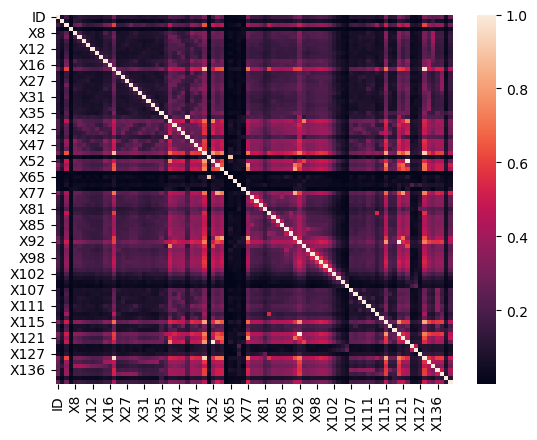

In [42]:
sns.heatmap(train_df.corr().abs())

In [43]:
#top_15_features = list(train_df.corr().abs().sort_values('label', ascending=False)['label'].head(15).index)

In [44]:
#train_df = train_df[top_15_features+['ID']]

##### Merging Processed Logs to Train data

In [45]:
train_df = train_df.merge(processed_logs, on='ID', how = 'left')

In [46]:
train_df.isna().sum()

ID                      0
X1                      0
X3                      0
X5                      0
X8                      0
                    ...  
event_page_close    36217
event_problem       36217
event_video         36217
days_active         36217
total_video_time    36217
Length: 114, dtype: int64

<Axes: >

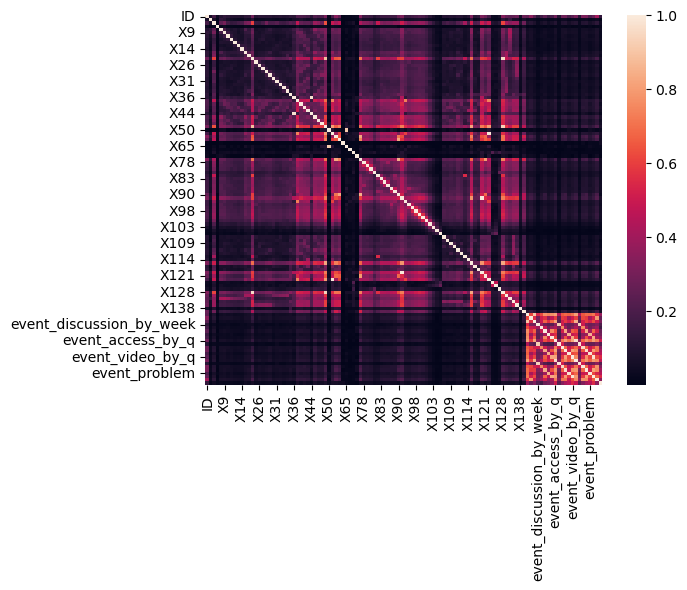

In [47]:
sns.heatmap(train_df.corr().abs())

In [48]:
# Handling NaNs
train_df.fillna(0.01, inplace=True)
#train_df.dropna(axis=0, inplace=True)

In [49]:
train_df.label.value_counts()

label
1    66520
0    17392
Name: count, dtype: int64

In [50]:
X = train_df.drop(['ID', 'label'], axis=1)
y = train_df.label

In [51]:
# imputer = IterativeImputer()
# X = imputer.fit_transform(X)
# X

## SMOTE

sampling = SMOTE(random_state=6, k_neighbors=10)

X, y = sampling.fit_resample(X, y)

y.value_counts()

# MODEL

##### Scaling and Splitting

In [52]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)


In [54]:
#X_train, y_train = sampling.fit_resample(X_train, y_train)

### XGBOOST

In [55]:
#model = XGBClassifier(eta=0.06, gamma=5)
model = XGBClassifier(n_estimators=1000, eta=0.09, max_depth=8)
model.fit(X_train,y_train)
pred = model.predict(X_test)
f1_score(pred,y_test), accuracy_score(pred,y_test)
#0.8774950843115057
# (0.9237606590547768, 0.8742775427515939)
# (0.9260536398467434, 0.8786036272145927) Drop Nans

(0.9256072874493927, 0.8773759161055831)

<Axes: >

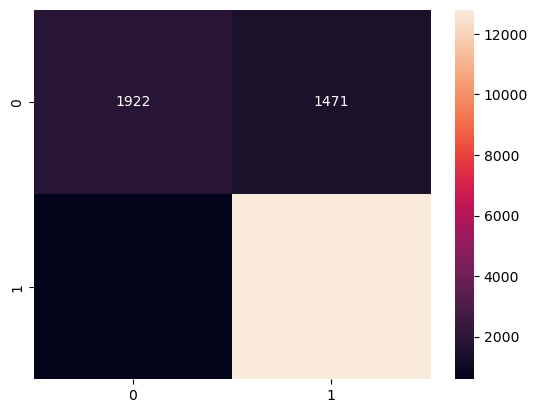

In [56]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')

### KNN

In [57]:
all_scores = {'Accuracy': [], 'Recall':[], 'Precision':[]}
k_vals = [3,5,6,7,8,9,10,50,60,80,100,150]

for k in k_vals:
    model = KNeighborsClassifier(k)
    kf = KFold(20,shuffle=True, random_state=42)
    
    scoring = ['accuracy', "precision_macro", "recall_macro"]
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring)

    mean_accuracy = scores['test_accuracy'].mean()
    mean_precision = scores['test_precision_macro'].mean()
    mean_recall = scores['test_recall_macro'].mean()
    all_scores['Accuracy'].append(mean_accuracy)
    all_scores['Precision'].append(mean_precision)
    all_scores['Recall'].append(mean_recall)
    
    print(f"k={k}: Accuracy={mean_accuracy}, Precision={mean_precision}, Recall={mean_recall}")

k=3: Accuracy=0.8433358235495294, Precision=0.788460866674419, Recall=0.6809838865423242
k=5: Accuracy=0.8504504090961253, Precision=0.8158084676788908, Recall=0.6825251215861887
k=6: Accuracy=0.8531675748854406, Precision=0.8039539193054985, Recall=0.7051525771071565
k=7: Accuracy=0.8526789064106686, Precision=0.826800637387741, Recall=0.6820737064246107
k=8: Accuracy=0.8559443751981283, Precision=0.8190638883771266, Recall=0.7002028338989362
k=9: Accuracy=0.853966045192027, Precision=0.8320059759861385, Recall=0.6828072577785773
k=10: Accuracy=0.8567309151913793, Precision=0.8265436654013623, Recall=0.6965257344653903
k=50: Accuracy=0.8543235086256166, Precision=0.8467500708469858, Recall=0.6751689611034081
k=60: Accuracy=0.8536442533953104, Precision=0.847594260131457, Recall=0.6725407950564758
k=80: Accuracy=0.852428685131762, Precision=0.8480197170681991, Recall=0.6685298683703838
k=100: Accuracy=0.8517017370536217, Precision=0.8477835283267208, Recall=0.6664280905610149
k=150: Ac

/Users/nmnsnghl/anaconda3/envs/torch_temp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nmnsnghl/anaconda3/envs/torch_temp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


''

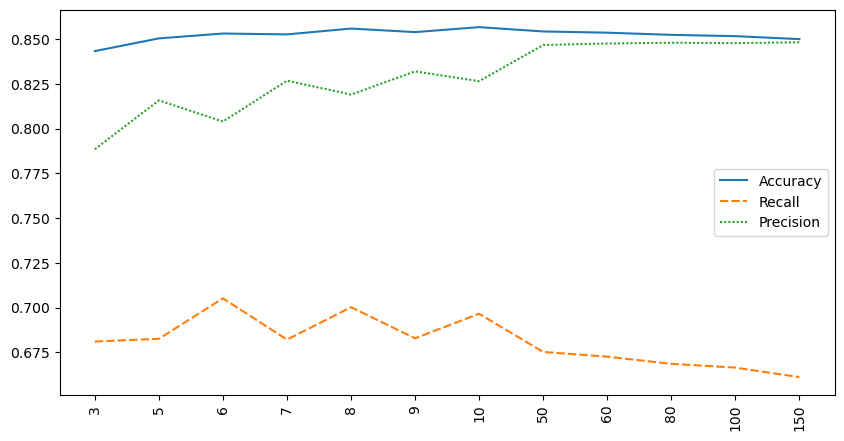

In [58]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(all_scores)
ax.set_xticks(list(range(len(k_vals))), k_vals)
plt.xticks(rotation=90)
""

In [59]:
model = KNeighborsClassifier(50)
model.fit(X_train,y_train)
pred = model.predict(X_test)

<Axes: >

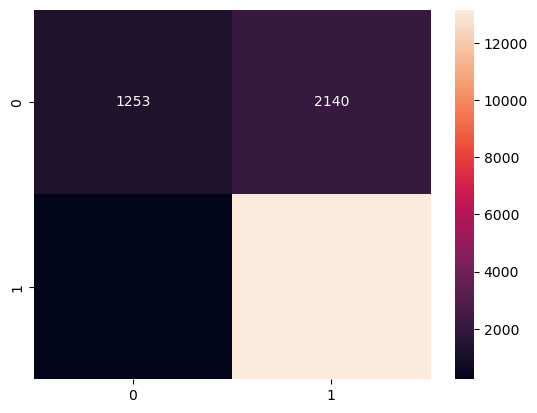

In [60]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')

## Log Reg

In [61]:
model = LogisticRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test)
f1_score(pred,y_test), accuracy_score(pred,y_test)

/Users/nmnsnghl/anaconda3/envs/torch_temp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.924622756203962, 0.8743967109575166)

# Submission file

In [62]:
# XGBOOST
model = XGBClassifier(n_estimators=1000, eta=0.09, max_depth=8)
model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.09, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [58]:
# KNN
model = KNeighborsClassifier(50)
model.fit(X,y)

KNeighborsClassifier(n_neighbors=50)

In [55]:
model = LogisticRegression()
model.fit(X,y)

LogisticRegression()

In [65]:
def cleaning_pipeline(df):
    df = filter_dummy_cols(test_df, keep_features[:-1])
    df = df.dropna(subset=['ID'])
    df = df.fillna(1.0)
    #X = df[top_15_features[1:]]
    df = df.merge(processed_logs, on='ID', how = 'left')
    df.fillna(0.01, inplace=True)
    # df.dropna(axis=0, inplace=True)
    X = df.drop(['ID'], axis=1)
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    
    return X

In [66]:
predictions = model.predict(cleaning_pipeline(test_df))

In [67]:
predictions.shape

(35982,)

In [68]:
sample_sub_df.head(2)

,ID,label
0,74337.0,0
1,48366.0,0


In [69]:
final_sub = test_df[['ID']]
final_sub['label'] = predictions

/var/folders/l8/l5y_29ps79df27jgbh6xp6n40000gn/T/ipykernel_16983/659565837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sub['label'] = predictions


In [70]:
final_sub.label.value_counts()
# 1    30510
# 0     5472

label
1    30547
0     5435
Name: count, dtype: int64

In [71]:
final_sub.to_csv('14_XGB_watch_time.csv',index=False)